**YOLOv8 Model**

In [ ]:
#Importing libraries
!pip install ultralytics

from ultralytics import YOLO
import os
import shutil
from PIL import Image, ImageEnhance
import random
import glob
from IPython.display import Image as IPImage, display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This code mounts the Google Drive into the Colab environment. By doing this,we can access files stored in the Google Drive (like datasets, models, etc.) directly from Colab. After mounting, all the Drive contents are available under /content/drive. It’s necessary because your dataset is stored in Drive.

In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/ocean_waste.v1i.yolov8.zip"  # path to ZIP file
extract_to = "/content/ocean_waste_yolo"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

Here, the dataset zip file is extracted from the Google Drive into the local Colab environment. zipfile.ZipFile is used to open the zip file located at zip_path, and extractall() extracts its contents into the specified folder /content/ocean_waste_yolo.

This prepares the dataset in the correct directory structure needed for YOLOv8 training (with folders like train/images, train/labels, etc.).

In [ ]:
yaml_code = """
path: /content/ocean_waste_yolo
train: train/images
val: valid/images
test: test/images
nc: 15
names: ['plastic_bag', 'bottle', 'can', 'net', 'glove', 'cup', 'straw', 'plastic',
        'container', 'wrapper', 'spoon', 'fork', 'rope', 'tube', 'fragment']
"""

with open("/content/ocean_waste_yolo/data.yaml", "w") as f:
    f.write(yaml_code)

This block defines the dataset configuration needed by YOLOv8 in YAML format. It specifies:

1. The path to the dataset,

2. The relative paths to the training, validation, and test images,

3. The number of classes (nc) which is 15,
and the list of class names (trash object types like plastic_bag, bottle, can, etc.).

This file is crucial because YOLO uses this YAML to understand the dataset structure and labels during training and prediction.

**Data Augmentation of Underrepresented Classes**

In [ ]:
input_img_dir = "/content/ocean_waste_yolo/train/images"
input_lbl_dir = "/content/ocean_waste_yolo/train/labels"
output_img_dir = "/content/ocean_waste_yolo/train/aug_data/images"
output_lbl_dir = "/content/ocean_waste_yolo/train/aug_data/labels"

os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_lbl_dir, exist_ok=True)

underrepresented_classes = {1, 6, 12, 13}  # Example

def augment_image(img):
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(0.8 + random.random() * 0.4)
    return img

for lbl_file in os.listdir(input_lbl_dir):
    if lbl_file.endswith(".txt"):
        lbl_path = os.path.join(input_lbl_dir, lbl_file)
        with open(lbl_path, "r") as f:
            lines = f.readlines()

        if any(int(line.split()[0]) in underrepresented_classes for line in lines):
            img_file = lbl_file.replace(".txt", ".jpg")
            img_path = os.path.join(input_img_dir, img_file)

            if os.path.exists(img_path):
                img = Image.open(img_path)
                aug_img = augment_image(img)
                aug_img.save(os.path.join(output_img_dir, img_file))
                shutil.copy(lbl_path, os.path.join(output_lbl_dir, lbl_file))

In [ ]:
!mkdir -p /content/ocean_waste_yolo/train_combined/images
!mkdir -p /content/ocean_waste_yolo/train_combined/labels

!cp /content/ocean_waste_yolo/train/images/* /content/ocean_waste_yolo/train_combined/images/
!cp /content/ocean_waste_yolo/train/labels/* /content/ocean_waste_yolo/train_combined/labels/
!cp /content/ocean_waste_yolo/train/aug_data/images/* /content/ocean_waste_yolo/train_combined/images/
!cp /content/ocean_waste_yolo/train/aug_data/labels/* /content/ocean_waste_yolo/train_combined/labels/

To address the issue of class imbalance in the underwater trash detection dataset, we first identify the underrepresented object classes (such as masks, ropes, tubes, and fragments) based on their lower occurrence in the training data. We create dedicated output folders to store augmented data separately. Then, a data augmentation strategy is implemented where, for every image containing one of these rare classes, random transformations are applied — including horizontal flipping and brightness adjustment. These techniques help to synthetically increase the diversity of the dataset without altering the original content of the images, making the model more robust to different lighting and orientation conditions typically encountered underwater. The augmented images and their corresponding labels are saved into new directories. Afterward, we merge both the original dataset and the augmented dataset into a single combined folder, ensuring that the model has access to a rich, balanced set of examples for training.

In [ ]:
model = YOLO('yolov8n.pt')

model.train(
    data="/content/ocean_waste_yolo/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    lr0=0.01,
    dropout=0.15,
    patience=10,    # Early stopping patience
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    flipud=0.2, fliplr=0.5,
    mosaic=1.0, mixup=0.0,
    name="yolov8_ocean_final",
    project="/content/drive/MyDrive/yolov8_results"
)

Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/ocean_waste_yolo/data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/yolov8_results, name=yolov8_ocean_final, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.15, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

100%|██████████| 755k/755k [00:00<00:00, 41.2MB/s]

Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

Model summary: 129 layers, 3,013,773 parameters, 3,013,757 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 181MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 792.6±372.8 MB/s, size: 25.6 KB)


train: Scanning /content/ocean_waste_yolo/train/labels... 3628 images, 2 backgrounds, 0 corrupt: 100%|██████████| 3628/3628 [00:01<00:00, 2274.94it/s]


train: New cache created: /content/ocean_waste_yolo/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 607.8±236.3 MB/s, size: 26.2 KB)


val: Scanning /content/ocean_waste_yolo/valid/labels... 1007 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1007/1007 [00:01<00:00, 882.54it/s]

val: New cache created: /content/ocean_waste_yolo/valid/labels.cache


Plotting labels to /content/drive/MyDrive/yolov8_results/yolov8_ocean_final/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/yolov8_results/yolov8_ocean_final
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.24G      1.461      3.346      1.626         65        640: 100%|██████████| 227/227 [01:11<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.87it/s]


                   all       1007       1909      0.519      0.206       0.18      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.86G      1.448      2.519      1.595         45        640: 100%|██████████| 227/227 [01:05<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


                   all       1007       1909       0.59      0.253      0.233      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.87G      1.465       2.36      1.603         43        640: 100%|██████████| 227/227 [01:05<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


                   all       1007       1909       0.61       0.26       0.26      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.89G      1.429      2.163      1.562         40        640: 100%|██████████| 227/227 [01:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


                   all       1007       1909      0.558      0.314      0.302      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       2.9G      1.411      2.041      1.543         48        640: 100%|██████████| 227/227 [01:06<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.21it/s]


                   all       1007       1909      0.632      0.279      0.268      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.92G       1.39      1.934      1.526         34        640: 100%|██████████| 227/227 [01:03<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


                   all       1007       1909      0.774      0.314      0.356      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.94G      1.389      1.847      1.527         44        640: 100%|██████████| 227/227 [01:03<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.28it/s]


                   all       1007       1909      0.694      0.303      0.314      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.96G      1.359      1.772        1.5         72        640: 100%|██████████| 227/227 [01:05<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


                   all       1007       1909      0.811      0.301      0.361      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.97G      1.341      1.704      1.492         43        640: 100%|██████████| 227/227 [01:05<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


                   all       1007       1909      0.841      0.318      0.381      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.99G      1.335      1.651      1.479         33        640: 100%|██████████| 227/227 [01:05<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


                   all       1007       1909      0.711      0.359      0.393      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.01G      1.325      1.603      1.475         43        640: 100%|██████████| 227/227 [01:03<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.25it/s]


                   all       1007       1909      0.711      0.396      0.429      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.02G      1.327      1.573      1.473         53        640: 100%|██████████| 227/227 [01:02<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.26it/s]


                   all       1007       1909      0.642      0.392      0.402      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.04G      1.306      1.488      1.451         40        640: 100%|██████████| 227/227 [01:03<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.25it/s]


                   all       1007       1909      0.585      0.419      0.446      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.06G      1.291      1.481      1.444         37        640: 100%|██████████| 227/227 [01:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


                   all       1007       1909      0.708        0.4      0.481      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.07G      1.268      1.427       1.43         35        640: 100%|██████████| 227/227 [01:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


                   all       1007       1909      0.583      0.385      0.436      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.09G      1.267      1.402       1.43         78        640: 100%|██████████| 227/227 [01:02<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


                   all       1007       1909      0.653      0.449        0.5       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.11G      1.273      1.405      1.432         49        640: 100%|██████████| 227/227 [01:03<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.07it/s]


                   all       1007       1909      0.561      0.488      0.514      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.12G      1.264      1.364      1.422         36        640: 100%|██████████| 227/227 [01:09<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


                   all       1007       1909      0.637      0.472      0.511      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.14G      1.235      1.302      1.407         46        640: 100%|██████████| 227/227 [01:10<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.12it/s]


                   all       1007       1909      0.595      0.497      0.511      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.16G      1.232      1.299        1.4         43        640: 100%|██████████| 227/227 [01:05<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.14it/s]


                   all       1007       1909      0.659      0.503       0.55      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.18G      1.219      1.261      1.386         31        640: 100%|██████████| 227/227 [01:07<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.61it/s]


                   all       1007       1909      0.527      0.552      0.599      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.19G      1.221      1.268      1.399         41        640: 100%|██████████| 227/227 [01:07<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.36it/s]

                   all       1007       1909      0.649      0.543      0.568      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.21G      1.205      1.239      1.383         66        640: 100%|██████████| 227/227 [01:05<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


                   all       1007       1909      0.539      0.544      0.559      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.22G      1.221       1.22      1.387         43        640: 100%|██████████| 227/227 [01:03<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.24it/s]


                   all       1007       1909      0.542      0.556      0.572      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.24G      1.194      1.196      1.368         61        640: 100%|██████████| 227/227 [01:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.52it/s]


                   all       1007       1909      0.687      0.542      0.605      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.26G      1.177      1.171      1.367         53        640: 100%|██████████| 227/227 [01:06<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]

                   all       1007       1909      0.694      0.527      0.598      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.28G      1.198      1.159       1.37         47        640: 100%|██████████| 227/227 [01:05<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.31it/s]

                   all       1007       1909      0.678      0.511      0.584      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.29G      1.177      1.144      1.356         36        640: 100%|██████████| 227/227 [01:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10<00:00,  3.15it/s]


                   all       1007       1909      0.772      0.506      0.613      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.31G      1.163      1.113      1.345         41        640: 100%|██████████| 227/227 [01:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


                   all       1007       1909      0.655       0.57      0.619      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.33G       1.17      1.117      1.351         53        640: 100%|██████████| 227/227 [01:05<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


                   all       1007       1909      0.616      0.563      0.598      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.35G      1.164      1.102      1.347         39        640: 100%|██████████| 227/227 [01:05<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


                   all       1007       1909      0.711      0.542      0.624      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.36G      1.144      1.081      1.339         32        640: 100%|██████████| 227/227 [01:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]

                   all       1007       1909      0.595      0.652      0.653      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.38G      1.145      1.057      1.328         41        640: 100%|██████████| 227/227 [01:02<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.65it/s]

                   all       1007       1909      0.734      0.568      0.634       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       3.4G      1.137      1.044      1.325         48        640: 100%|██████████| 227/227 [01:02<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

                   all       1007       1909      0.676      0.612      0.669      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.41G      1.131      1.036      1.328         45        640: 100%|██████████| 227/227 [01:02<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


                   all       1007       1909       0.69      0.614      0.675      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.43G       1.12      1.004      1.319         85        640: 100%|██████████| 227/227 [01:02<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


                   all       1007       1909      0.679      0.609      0.665      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.45G      1.119      1.013      1.314         48        640: 100%|██████████| 227/227 [01:02<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


                   all       1007       1909      0.708      0.603      0.674       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.46G      1.109     0.9955      1.309         49        640: 100%|██████████| 227/227 [01:02<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]


                   all       1007       1909      0.684      0.647      0.704      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.48G      1.109     0.9891      1.308         93        640: 100%|██████████| 227/227 [01:03<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]

                   all       1007       1909      0.738      0.619      0.698       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       3.5G      1.109     0.9774      1.309         53        640: 100%|██████████| 227/227 [01:03<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


                   all       1007       1909      0.716        0.6      0.686      0.442
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.52G      1.061     0.8396      1.308         30        640: 100%|██████████| 227/227 [01:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.54it/s]


                   all       1007       1909      0.747      0.623      0.705      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.53G       1.04     0.7944      1.307         33        640: 100%|██████████| 227/227 [01:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


                   all       1007       1909      0.718      0.655      0.711      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.55G      1.026     0.7625      1.284         19        640: 100%|██████████| 227/227 [00:59<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.25it/s]


                   all       1007       1909      0.794      0.642      0.744      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.57G      1.023     0.7574      1.285         22        640: 100%|██████████| 227/227 [01:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


                   all       1007       1909      0.805      0.674       0.76      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.59G      1.014     0.7455      1.277         16        640: 100%|██████████| 227/227 [01:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.25it/s]


                   all       1007       1909       0.77      0.701      0.758      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       3.6G      1.011       0.74      1.279         24        640: 100%|██████████| 227/227 [01:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]


                   all       1007       1909      0.803      0.668       0.76      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.62G      1.006     0.7205      1.272         29        640: 100%|██████████| 227/227 [01:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]

                   all       1007       1909      0.748      0.727      0.777      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.63G     0.9952     0.7154      1.264         31        640: 100%|██████████| 227/227 [01:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]

                   all       1007       1909      0.786      0.694      0.775      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.65G     0.9779     0.6927      1.255         26        640: 100%|██████████| 227/227 [01:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]

                   all       1007       1909      0.797      0.691      0.777      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.67G     0.9822     0.6978       1.26         20        640: 100%|██████████| 227/227 [01:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


                   all       1007       1909      0.734      0.747      0.776      0.501

50 epochs completed in 1.028 hours.
Optimizer stripped from /content/drive/MyDrive/yolov8_results/yolov8_ocean_final/weights/last.pt, 6.3MB
Optimizer stripped from /content/drive/MyDrive/yolov8_results/yolov8_ocean_final/weights/best.pt, 6.3MB

Validating /content/drive/MyDrive/yolov8_results/yolov8_ocean_final/weights/best.pt...
Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]


                   all       1007       1909      0.747      0.729      0.777      0.505
           plastic_bag         79         92       0.94      0.815      0.908      0.664
                bottle         18         20      0.612        0.7      0.753      0.242
                   can         61         71      0.987      0.972      0.991      0.876
                   net         27         40      0.704      0.775      0.769      0.465
                 glove         36         82      0.617      0.817      0.795      0.565
                   cup         38         57      0.874       0.85      0.919      0.733
                 straw         10         22      0.592      0.463      0.438      0.249
               plastic         48         51      0.753      0.598      0.701      0.413
             container        147        149      0.837      0.897      0.937       0.64
               wrapper        291        331      0.858      0.967       0.98      0.842
                 spoo

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bfc43880290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,   

Following this preparation, we train a YOLOv8n model, starting from pre-trained weights (yolov8n.pt) to leverage prior learning. We use a comprehensive training strategy where 50 epochs are set, with a standard input image size of 640×640 pixels. The training further benefits from several types of real-time augmentations during learning, such as color shifts (hsv adjustments), image flipping (flipud, fliplr), and more advanced techniques like mosaic and mixup to create variations between images dynamically. A dropout rate of 0.15 is used to reduce overfitting, and early stopping with a patience of 10 epochs is introduced to halt training if no meaningful improvement is detected. The model training outputs are organized under a specified project directory on Google Drive, making it easier to access and evaluate the results.


In [ ]:
results = model.predict(
    source="/content/ocean_waste_yolo/test/images",
    imgsz=640,
    save=True,
    project="/content/drive/MyDrive/yolov8_results",
    name="yolov8_ocean_final_pred"
)


image 1/501 /content/ocean_waste_yolo/test/images/1bc7-iudfmpmn7245599_jpg.rf.c753c3518aa3bd30463da5e4b94a48be.jpg: 640x640 1 cup, 1 container, 8.9ms
image 2/501 /content/ocean_waste_yolo/test/images/200623160205-05-coronavirus-waste-pollution-super-169_jpg.rf.e06b1a6873ec4240c3493f281822c9d9.jpg: 640x640 1 plastic_bag, 7.3ms
image 3/501 /content/ocean_waste_yolo/test/images/66b85ac2-5d1b-4783-b0fa-4f8adcda51a5_jpg.rf.33eb90a2198eccbfbc6e7961b953ac4a.jpg: 640x640 2 plastic_bags, 1 cup, 1 plastic, 1 wrapper, 7.3ms
image 4/501 /content/ocean_waste_yolo/test/images/7_JPG_jpg.rf.3bf999e1c1e0a9a932b23d95b27357dc.jpg: 640x640 1 plastic_bag, 7.2ms
image 5/501 /content/ocean_waste_yolo/test/images/GettyImages-1227891345-1000x667_jpg.rf.32ae9a5a4e410851af33ae743636ac1a.jpg: 640x640 2 plastic_bags, 1 wrapper, 1 spoon, 1 fork, 7.3ms
image 6/501 /content/ocean_waste_yolo/test/images/GettyImageskl-1227891345-1000x667_jpg.rf.b1b21e076c5e516af46499d92e4d57d8.jpg: 640x640 1 plastic_bag, 1 fork, 8.9ms

After successfully training the YOLOv8 model, we move on to the prediction phase. In this block, we use the model.predict function to apply our trained model to the test images and evaluate its performance. The source parameter points to the folder containing the test images (/content/ocean_waste_yolo/test/images) on which we want to make predictions. Each image is resized to 640×640 pixels (imgsz=640) to match the training input size, ensuring consistency in feature extraction. The save=True argument ensures that all the prediction results — including bounding boxes, class labels, and confidence scores are saved automatically. These outputs are organized under the specified project directory on Google Drive, grouped neatly under a subfolder named yolov8_ocean_final_pred. During execution, the model processes each test image one by one and outputs predictions such as detected objects (e.g., plastic bag, cup, wrapper) along with the processing speed for each image. This detailed logging provides insight into both the detection results and the computational efficiency of the model. Overall, this prediction step validates how well the fine-tuned model can correctly identify and classify different types of marine waste in underwater scenes.

Found: 501 images


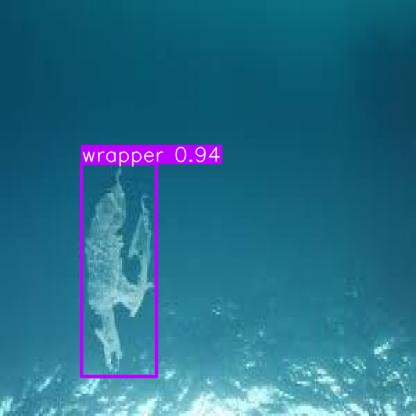

In [ ]:
predicted_imgs = glob.glob("/content/drive/MyDrive/yolov8_results/yolov8_ocean_final_pred/**/*.jpg", recursive=True)

print("Found:", len(predicted_imgs), "images")

if predicted_imgs:
    display(IPImage(filename=random.choice(predicted_imgs)))
else:
    print("No prediction images found.")

In this final step, we visualize the model's predictions to qualitatively assess its performance. The code first gathers all the .jpg prediction images saved during the prediction phase from the project directory (/content/drive/MyDrive/yolov8_results/yolov8_ocean_final_pred) using the glob function, allowing recursive search through subdirectories. It then prints the total number of prediction images found, giving a quick confirmation that the prediction phase has successfully generated outputs. If predicted images are found, one image is randomly selected and displayed using IPImage from the IPython display module. This allows us to visually inspect how well the model is detecting and classifying marine debris, with bounding boxes and class labels clearly drawn on the images. If no images are found, an appropriate error message is printed. This step is for quick manual verification to ensure that different types of trash are being detected correctly and consistently by the model.